In [48]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from unidecode import unidecode
import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize

## Czyszczenie danych

In [40]:
df_raw = pd.read_csv(
    r"data\descriptions\training_data_recznie_poprawione.csv", header=0, sep=";"
)
df = df_raw.copy()
df.head()

,Label,Opis
0,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
3,2,Na wynajem - jasne i przytulne mieszkanie dwup...
4,2,"[PL/EN] Piękne, stylowe i wysmakowan..."


In [41]:
df = df.reset_index()
df.head()

,index,Label,Opis
0,0,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,1,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,2,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
3,3,2,Na wynajem - jasne i przytulne mieszkanie dwup...
4,4,2,"[PL/EN] Piękne, stylowe i wysmakowan..."


In [43]:
df["Label"].value_counts()

Label
2    273
0    259
1    235
Name: count, dtype: int64

### Zapisanie opisów małymi literami

In [44]:
df["Opis"] = df["Opis"].str.lower()
df["Opis"][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul. bruzdowej 100d. mieszkanie gotowe do wynajęcia, dostępne od zaraz, częściowo umeblowane (kuchnia, łazienka i przedpokój). wygodne, przestronne, w sypialni duża szafa, ogródek około 40 m2. sypialnia o powierzchni 15 m2 z dużymi oknami i roletami. do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie -1 w cenie 350 zł. komunikacja autobusowa przy placu vogla i ulicy sytej, tam też znajduje się mini galeria, lidl, biedronka, restauracje, punkty usługowe, miejsca spotkań. osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego, tuż za wałem jest wisła, dużo zieleni, miejsc do spacerów, trasa rowerowa, wiślańskie plaże. podana cena jest bez czynszu administracyjnego, który wynosi 950 zł. wymagany najem okazjonalny. zapraszam zobacz wirtualny spacer: https://panoramy.galactica.pl/virgo/423768pośrednik odpowiedzialny zawodowo za wykonanie umowy pośrednictwa:  (licencja

### Usunięcie ukraińskich znaków

In [39]:
ukrainian_desc = '''
2 wolnostojących domy na działce 1700 m.kw. ul. Beskidzka Rzeszów - 21 pokój mieszkalny, umeblowany, magazyn, Dwa garaży (30 m.kw i 40 m.kw). Idealna nieruchomość dla firmy , usług, mieszkania dla pracowników. Stan bardzo dobry, wyposażony. Dodatkowa informacja - dzwonić jest możliwość wynajmu osobno każdego budynku
2 окремих будинки на ділянці 1700 кв.м. вул. Beskidzka Rzeszów - 21 житлова кімната, мебльована, склад, два гаражі (30 кв. м та 40 кв. м). Ідеальна нерухомість під компанію, послуги, житло для співробітників. Дуже хороший стан, укомплектований. Додаткова інформація - можлива оренда кожної будівлі окремо
'''

def remove_ukrainian_characters(text):
    
    pattern = "[а-яА-ЯіІїЇєЄ]+"
    return re.sub(pattern, "", text)

remove_ukrainian_characters(ukrainian_desc)

'\n2 wolnostojących domy na działce 1700 m.kw. ul. Beskidzka Rzeszów - 21 pokój mieszkalny, umeblowany, magazyn, Dwa garaży (30 m.kw i 40 m.kw). Idealna nieruchomość dla firmy , usług, mieszkania dla pracowników. Stan bardzo dobry, wyposażony. Dodatkowa informacja - dzwonić jest możliwość wynajmu osobno każdego budynku\n2     1700 .. . Beskidzka Rzeszów - 21  , , ,   (30 .   40 . ).    , ,   .   , .   -     \n'

In [45]:
df["Opis"] = df["Opis"].apply(remove_ukrainian_characters)

### Usunięcie linków, znaków specjalnych, interpunkcji oraz liczb

In [46]:
from string import digits

def remove_special_chars(text):
    if text is not None:
        text = text.replace('www','https://www')
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
        cleaned_text = re.sub(r"[^\w\s]", "", text)
        cleaned_text = ''.join(filter(lambda x: not x.isdigit(), cleaned_text))
        return cleaned_text
    else:
        return None
    


df["Opis"] = df["Opis"].str.replace("\d+", "")
df["Opis"] = df["Opis"].apply(remove_special_chars)

df["Opis"][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul bruzdowej 100d mieszkanie gotowe do wynajęcia dostępne od zaraz częściowo umeblowane kuchnia łazienka i przedpokój wygodne przestronne w sypialni duża szafa ogródek około 40 m2 sypialnia o powierzchni 15 m2 z dużymi oknami i roletami do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie 1 w cenie 350 zł komunikacja autobusowa przy placu vogla i ulicy sytej tam też znajduje się mini galeria lidl biedronka restauracje punkty usługowe miejsca spotkań osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego tuż za wałem jest wisła dużo zieleni miejsc do spacerów trasa rowerowa wiślańskie plaże podana cena jest bez czynszu administracyjnego który wynosi 950 zł wymagany najem okazjonalny zapraszam zobacz wirtualny spacer  odpowiedzialny zawodowo za wykonanie umowy pośrednictwa  licencja nr 24900'

### Stemming i lemantyzacja

In [47]:
nlp = spacy.load("pl_core_news_md")

opisy_mieszkan = df["Opis"]

przetworzone_opisy = []
for opis in df["Opis"]:
    doc = nlp(opis)
    przetworzony_opis = " ".join([token.lemma_ for token in doc if not token.is_stop])
    przetworzone_opisy.append(przetworzony_opis)

df["Opis"] = przetworzone_opisy
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy 100d mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek 40 m2 sypialnia powierzchnia 15 imio2 duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom 1 cena 350 złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić 950 złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer 24900'

### Usunięcie pojedyńczych znaków pozwstałych w trakcie czyszczenia tekstu

In [29]:
def remove_single_letters(text):
    return re.sub(r"\b\w\b\s*", "", text)


# Zastosowanie funkcji do kolumny 'opis_mieszkania'
df["Opis"] = df["Opis"].apply(remove_single_letters)
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy 100d mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek 40 m2 sypialnia powierzchnia 15 imio2 duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom cena 350 złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić 950 złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer 24900'

### Usunięcie polskich znaków

In [30]:
df["Opis"] = df["Opis"].apply(unidecode)
df["Opis"][0]

'wynajac mieszkanie dwupokojowy ogrodek garaz wilanowa zawada ulica bruzdowy 100d mieszkanie gotowy wynajac dostepny zaraz czesciowo umeblowac kuchnia lazienka przedpokoj wygodny przestronny sypialnia duzy szafa ogrodek 40 m2 sypialnia powierzchnia 15 imio2 duzy okno rolet mieszkanie przynalezec miejsce parkingowy duzy komorka lokatorsky poziom cena 350 zloty komunikacja autobusowy plac vogla ulica syty znajdowac mini galeria lidl biedronka restauracja punkt uslugowy miejsce spotkanie osiedle zamkniety wyjscie wyjazd wal zawadowskiy tuz wal wisly zielen miejsce spacer trasa rowerowy wislanski plaza podac cena czynsz administracyjny wynosic 950 zloty wymagac najem okazjonalny zapraszac zobaczyc wirtualny spacer   odpowiedzialny zawodowo wykonac umowa posrednictwo   licencja numer 24900'

### Podział na dane treningowe i testowe

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

## Wektoryzacja danych tekstowych z wykorzystaniem macierzy TF-IDF
TfidfVectorizer przekształca listę opisów na macierz numeryczną, w której każdy wiersz odpowiada jednemu opisowi, a każda kolumna odpowiada jednemu unikalnemu słowu. Wartości w macierzy TF-IDF są obliczane dla każdego słowa w każdym opisie. Wagi odzwierciedlają istotność danego słowa w konkretnym opisie w kontekście całego zbioru opisów.

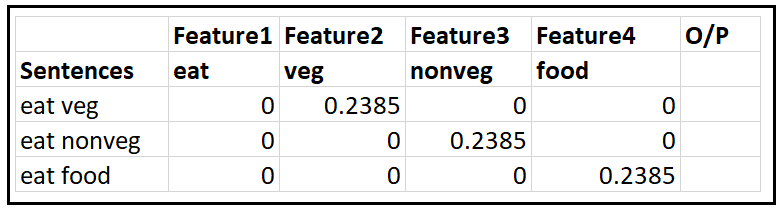

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=80)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Model maszyny wektorów nośnych

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_clf = SVC(C=2, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8515497553017944
Dokładność na zbiorze testowym: 0.8376623376623377

              precision    recall  f1-score   support

           0       0.77      0.80      0.78        50
           1       0.78      0.76      0.77        46
           2       0.95      0.93      0.94        58

    accuracy                           0.84       154
   macro avg       0.83      0.83      0.83       154
weighted avg       0.84      0.84      0.84       154



**Opis klas:**
- 0: mieszkanie jest nieumeblowane
- 1: mieszkanie jest umeblowane
- 2: mieszkanie jest częściowo umeblowane

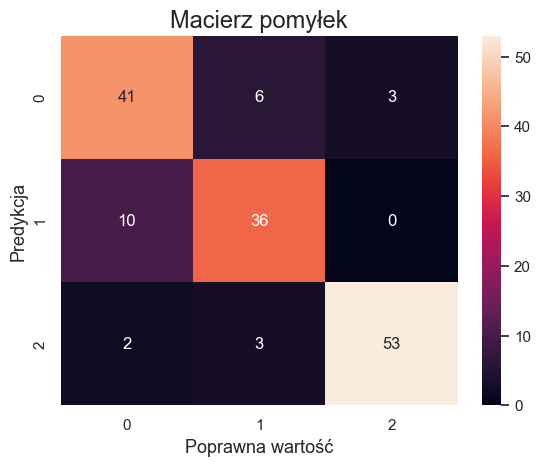

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model drzewa decyzyjnego

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8694942903752039
Dokładność na zbiorze testowym: 0.8961038961038961

              precision    recall  f1-score   support

           0       0.95      0.78      0.86        50
           1       0.83      0.96      0.89        46
           2       0.92      0.95      0.93        58

    accuracy                           0.90       154
   macro avg       0.90      0.89      0.89       154
weighted avg       0.90      0.90      0.89       154



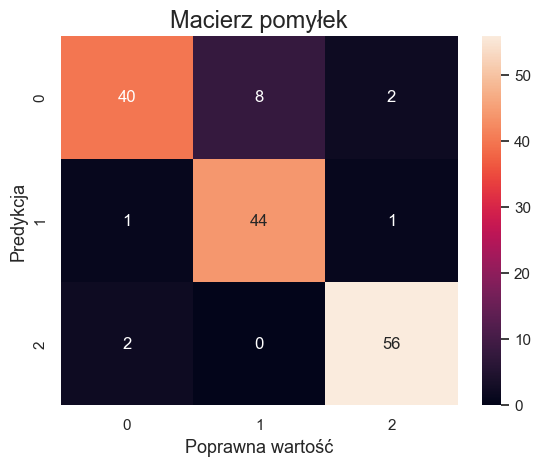

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model regresji logistycznej

In [36]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {logreg_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {logreg_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8417618270799347
Dokładność na zbiorze testowym: 0.8051948051948052

              precision    recall  f1-score   support

           0       0.75      0.76      0.75        50
           1       0.77      0.72      0.74        46
           2       0.88      0.91      0.90        58

    accuracy                           0.81       154
   macro avg       0.80      0.80      0.80       154
weighted avg       0.80      0.81      0.80       154



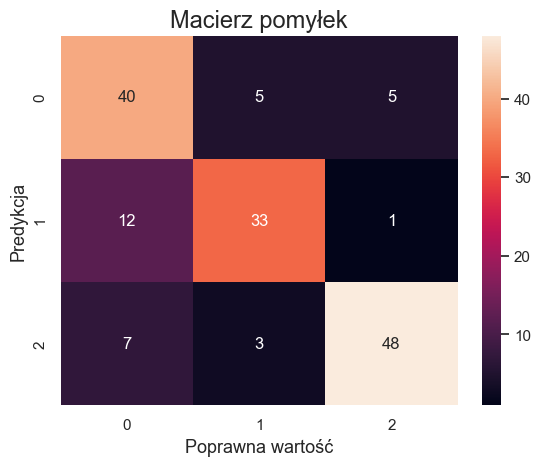

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model lasów losowych

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(100, max_depth=3, criterion="entropy")
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {rf_clf.score(X_train, y_train)}\n")
print(f"Dokładność na zbiorze testowym: {rf_clf.score(X_test, y_test)}")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.9004893964110929

Dokładność na zbiorze testowym: 0.8311688311688312
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        50
           1       0.82      0.67      0.74        46
           2       0.92      0.98      0.95        58

    accuracy                           0.83       154
   macro avg       0.83      0.82      0.82       154
weighted avg       0.83      0.83      0.83       154



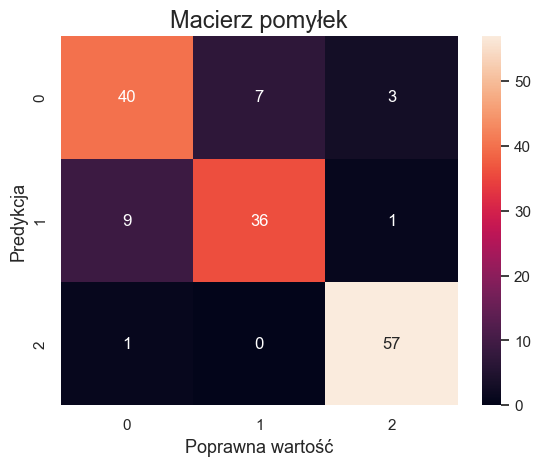

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem funkcji CountVectorizer
CountVectorizer przekształca listę opisów na macierz numeryczną, w której każdy wiersz odpowiada jednemu dokumentowi, a każda kolumna odpowiada jednemu unikalnemu słowu. Wartości w tej macierzy to liczby całkowite reprezentujące ile razy dany termin występuje w danym dokumencie.

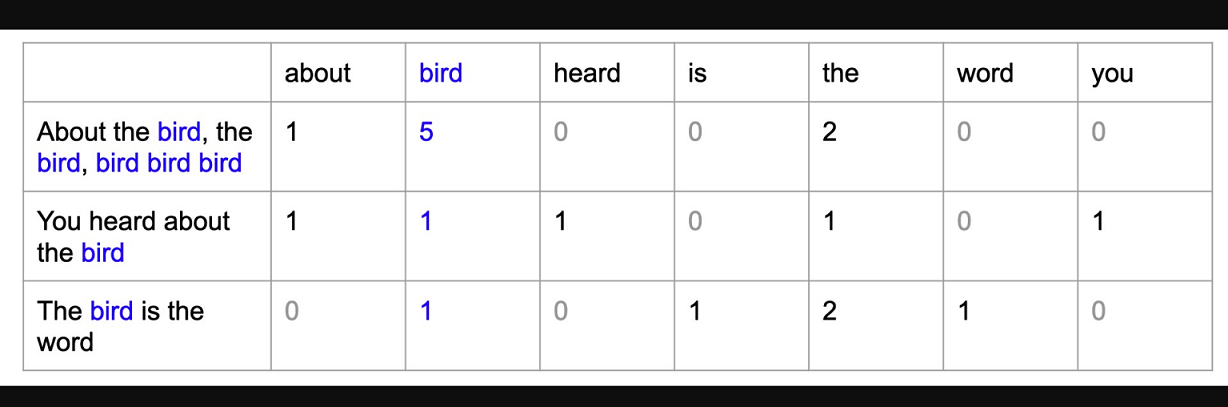

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

count_vec = CountVectorizer()
X_train = count_vec.fit_transform(X_train)
X_test = count_vec.transform(X_test)

### Model drzewa decyzyjnego

In [21]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8809135399673735
Dokładność na zbiorze testowym: 0.8896103896103896

              precision    recall  f1-score   support

           0       0.90      0.76      0.83        50
           1       0.83      0.96      0.89        46
           2       0.93      0.95      0.94        58

    accuracy                           0.89       154
   macro avg       0.89      0.89      0.89       154
weighted avg       0.89      0.89      0.89       154



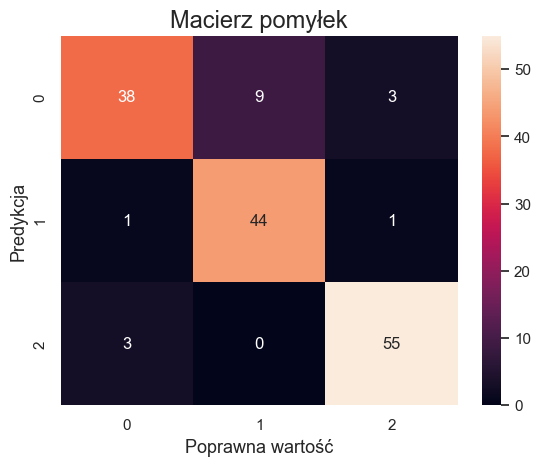

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [23]:
svm_clf = SVC(C=3, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 1.0
Dokładność na zbiorze testowym: 0.8246753246753247

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        50
           1       0.75      0.78      0.77        46
           2       0.95      0.91      0.93        58

    accuracy                           0.82       154
   macro avg       0.82      0.82      0.82       154
weighted avg       0.83      0.82      0.83       154



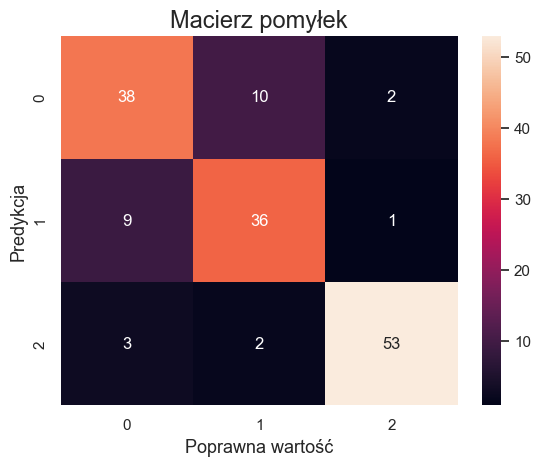

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem Bi-Gramów
W tym przypadku CountVectorizer będzie brał pod uwagę zarówno pojedyncze słowa, jak i pary sąsiadujących słów.

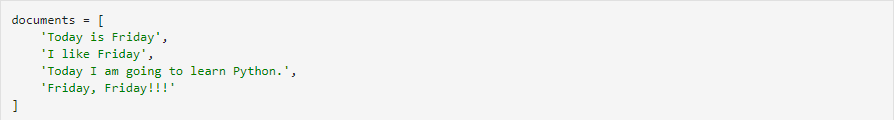
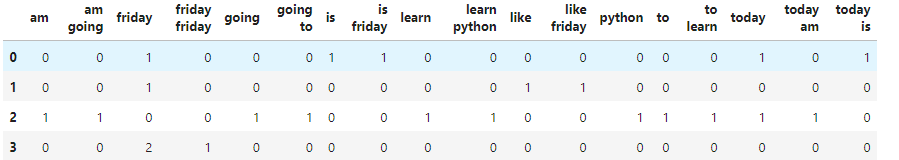

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

bigram = CountVectorizer(ngram_range=(1, 2))
X_train = bigram.fit_transform(X_train)
X_test = bigram.transform(X_test)

### Model drzewa decyzyjnego

In [26]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8809135399673735
Dokładność na zbiorze testowym: 0.9090909090909091

              precision    recall  f1-score   support

           0       0.93      0.78      0.85        50
           1       0.83      0.96      0.89        46
           2       0.97      0.98      0.97        58

    accuracy                           0.91       154
   macro avg       0.91      0.91      0.90       154
weighted avg       0.91      0.91      0.91       154



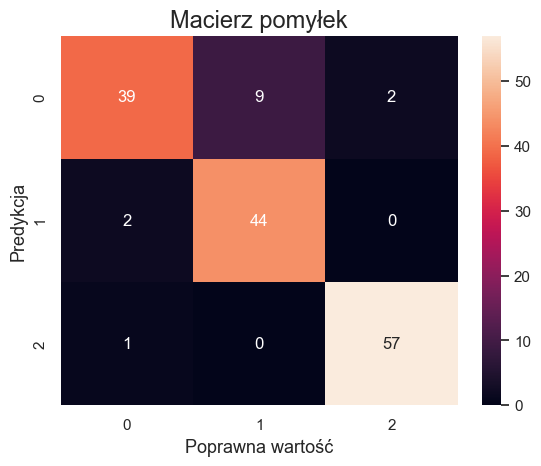

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [28]:
svm_clf = SVC(C=3, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 1.0
Dokładność na zbiorze testowym: 0.8181818181818182

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        50
           1       0.80      0.76      0.78        46
           2       0.94      0.88      0.91        58

    accuracy                           0.82       154
   macro avg       0.82      0.81      0.81       154
weighted avg       0.83      0.82      0.82       154



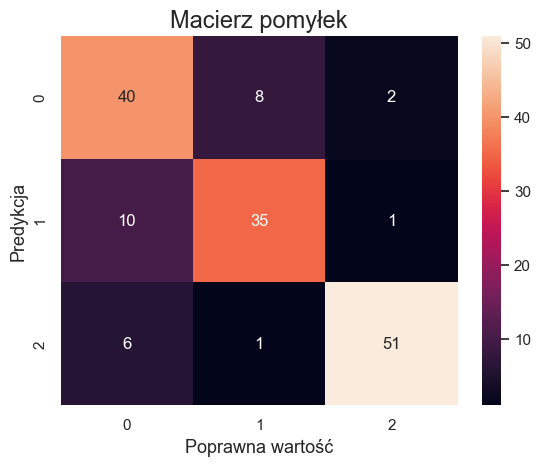

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

In [42]:
def one_sample_predict(model, train_data):
    """ Funkcja przyjmuje wytrenowany model oraz jego dane treningowe w postaci tekstowej. 
    Pobiera od użytkownika pojedyńczy opis przetwarzając go i zwracając predykcję """
    text = input("Podaj opis: ")
    tfidf = TfidfVectorizer(max_features=80)
    _ = tfidf.fit_transform(train_data)
    classes = ["nieumeblowane", "umeblowane", "częściowo umeblowane"]
    text = text.lower()
    cleaned_text = re.sub("\d+", "", text)
    cleaned_text = re.sub(r"http\S+", "", cleaned_text)
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)

    doc = nlp(cleaned_text)
    cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop])

    cleaned_text = re.sub(r"\b\w\b\s*", "", cleaned_text)
    vectorized_text = tfidf.transform([cleaned_text])

    pred = model.predict(vectorized_text)
    return classes[pred[0]]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

one_sample_predict(svm_clf, X_train)

'częściowo umeblowane'